# 03 - Modeling Preparation and Baseline

This notebook prepares the dataset for machine learning by encoding categorical variables, splitting the dataset into training and testing sets, and creating a baseline model for comparison.


In [29]:
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
# Load pre-cleaned dataset
df = pd.read_csv('../data/processed/cleaned_customer_data.csv')
df.head()


,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
0,40,1,66120.267939,8,0,30.568601,0,5,1
1,20,1,23579.773583,4,2,38.240097,0,5,0
2,27,1,127821.306432,11,2,31.633212,1,0,1
3,24,1,137798.623120,19,3,46.167059,0,4,1
4,31,1,99300.964220,19,1,19.823592,0,0,1


In [31]:
# Verifying the dtypes
df.dtypes

Age                     int64
Gender                  int64
AnnualIncome          float64
NumberOfPurchases       int64
ProductCategory         int64
TimeSpentOnWebsite    float64
LoyaltyProgram          int64
DiscountsAvailed        int64
PurchaseStatus          int64
dtype: object

---

## Step 1: Re-encode Categorical Features

When I reloaded the cleaned data, I noticed pandas had dropped the category types I had originally set.  
To prepare for modeling, I decided to manually recast and encode relevant categorical columns. This helps ensure that machine learning models interpret these fields correctly.


In [32]:
from sklearn.preprocessing import OneHotEncoder

In [33]:
# Columns to manually treat as categorical
categorical_binary = ['Gender', 'LoyaltyProgram', 'PurchaseStatus']
categorical_multi = ['ProductCategory']

# Convert binary columns to category dtype
df[categorical_binary] = df[categorical_binary].astype('category')

# OneHot Encode the ProductCategory
df = pd.get_dummies(df , columns = categorical_multi, prefix = 'ProductCat')

# Confirm changes
df.dtypes

Age                      int64
Gender                category
AnnualIncome           float64
NumberOfPurchases        int64
TimeSpentOnWebsite     float64
LoyaltyProgram        category
DiscountsAvailed         int64
PurchaseStatus        category
ProductCat_0              bool
ProductCat_1              bool
ProductCat_2              bool
ProductCat_3              bool
ProductCat_4              bool
dtype: object

---

## Step 2: Train-Test Split

Now that the features are fully prepared, I created the training and test sets.  

This helps ensure the model is validated on unseen data, and gives me a benchmark to measure real-world generalization.


In [34]:
from sklearn.model_selection import train_test_split

In [35]:
# Target variable
y = df['PurchaseStatus']

# Feature set (drop target + original category column if still present)
X = df.drop(['PurchaseStatus'], axis = 1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

# Shape check
X_train.shape, X_test.shape

((1200, 12), (300, 12))

---

## Step 3: Baseline Model - Random Forest Classifier

To establish a baseline, I trained a `RandomForestClassifier` with default parameters.  
This gives me a reference point to compare future improvements using hyperparameter tuning or different models.


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       170
           1       0.93      0.88      0.90       130

    accuracy                           0.92       300
   macro avg       0.92      0.91      0.92       300
weighted avg       0.92      0.92      0.92       300



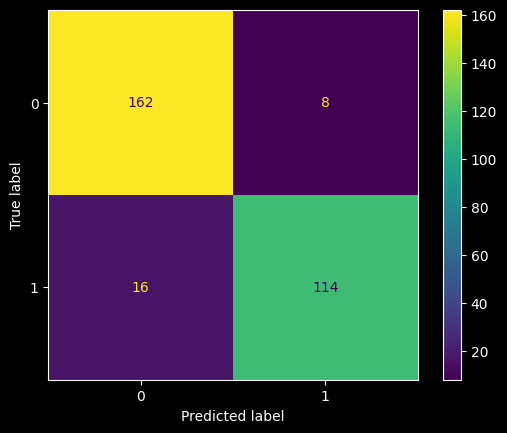

In [37]:
# Initialize default model
rf_baseline = RandomForestClassifier(random_state = 42)

# Train mode
rf_baseline.fit(X_train, y_train)

# Make prediction
y_pred = rf_baseline.predict(X_test)

# Evaluate the baseline model
print('Classification Report:')
print(classification_report(y_test, y_pred))

rf_baseline_cm = confusion_matrix(y_test, y_pred)

rf_cm_disp = ConfusionMatrixDisplay(rf_baseline_cm, display_labels = rf_baseline.classes_)

rf_cm_disp.plot(values_format = '')
plt.show()


### Baseline Model Results

The baseline Random Forest model actually performed better than I expected.  
With zero tuning, I got an overall **accuracy of 92%**, and a **weighted F1 score of 0.92**.

What really caught my eye was the balance:  
- **Recall for purchasers (class 1)** was 88%, meaning the model correctly identified most buyers. 
- **Precision for purchasers** was 93%, so false positives were minimal.

The confusion matrix showed a few missed buyers (16), but for a baseline model, this is a strong foundation. It confirms that the features have predictive power,and gives me a reliable benchmark for comparing tuned models later.

---


## Step 4: Hyperparameter Tuning - GridSearchCV

After establishing a solid baseline, I wanted to see if I could improve performance by tuning the Random Forest's key hyperparameters. 

I used GridSearchCV with 5-fold cross-validation to search for the best combination of parameters across a small grid.


In [38]:
# import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [39]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth' : [None, 10, 20],
    'min_samples_split' : [2, 5],
    'min_samples_leaf' : [1,2]
    }

# Grid Search Setup

grid_search = GridSearchCV(
    estimator = RandomForestClassifier(random_state=42),
    param_grid = param_grid,
    scoring = 'f1',
    cv = 5,
    n_jobs=-1,
    verbose=1
)

In [40]:
%%time
# Fit to training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: total: 766 ms
Wall time: 15.1 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=1)

In [41]:
# Best model
print('Best Parameters: ', grid_search.best_params_)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


---

## Step 5: Tuned Model Evaluation

Once I had the best hyperparameters from GridSearchCV, I evaluated the tuned model on the test set to see how much improvement I gained over the baseline.

I focused primarily on **F1 Score** and **Recall** for purchasers, since minimizing false negatives is especially important in this context.


Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       170
           1       0.94      0.88      0.91       130

    accuracy                           0.93       300
   macro avg       0.93      0.92      0.92       300
weighted avg       0.93      0.93      0.93       300



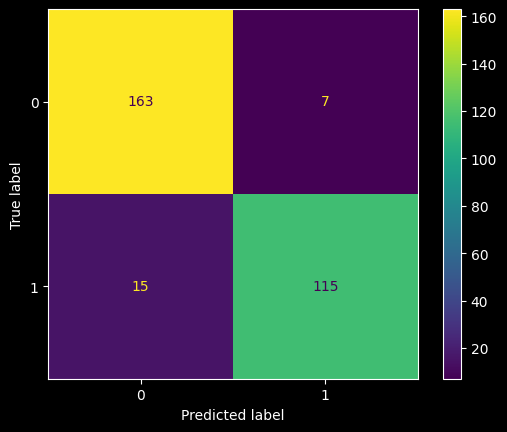

In [42]:
# Predict with the best model
best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)

# Evaluation
print('Classification Report (Tuned Model):')
print(classification_report(y_test, y_pred_best))

tuned_cm = confusion_matrix(y_test, y_pred_best)

tuned_cm_disp = ConfusionMatrixDisplay(tuned_cm, display_labels = best_rf.classes_)

tuned_cm_disp.plot(values_format = '')
plt.show()

In [43]:
# Display the result of baseline vs gradient boosted in a table
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
pd.DataFrame({
    'Model': ['Random Forest (Baseline Model)', 'Random Forest (Tuned Model)'],
    'F1-Score': [round(f1_score(y_test, y_pred),2), round(f1_score(y_test, y_pred_best),2)],
    'Accuracy': [round(accuracy_score(y_test, y_pred),2), round(accuracy_score(y_test, y_pred_best),2)],
    'Recall' : [round(recall_score(y_test, y_pred),2), round(recall_score(y_test, y_pred_best),2)],
    'Precision' : [round(precision_score(y_test, y_pred),2), round(precision_score(y_test, y_pred_best),2)]
})


,Model,F1-Score,Accuracy,Recall,Precision
0,Random Forest (Baseline Model),0.90,0.92,0.88,0.93
1,Random Forest (Tuned Model),0.91,0.93,0.88,0.94


### Tuned Model Results

After tuning the Random Forest model with GridSearchCV, I saw a small but meaningful improvement. 

The F1 score for the purchasing class improved from **0.90 to 0.91**, and overall accuracy increased from **92% to 93%**.

Precision for purchasers increased slightly as well, indicating fewer false positives.  

Interestingly, recall remained the same, suggesting the model’s sensitivity to actual purchasers was already strong in the baseline model, and tuning helped reduce overprediction instead.

Overall, this tuned model is what I would consider production-ready for this case study, with strong generalization and well-balanced performance.

---